In [1]:
#Library 설치
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## <월별 경부선 승차수요>

# 데이터 불러오기
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240602_data.xlsx"
df = pd.read_excel(file_path)

# '경부선' 필터링 후 복사본 생성
df_gbline = df[df['주운행선'] == '경부선'].copy()

# 운행년월, datetime 형식으로 변환
df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')

# 기간 필터링
train_data = df_gbline[(df_gbline['운행년월'] >= '2015-01-01') & (df_gbline['운행년월'] <= '2023-03-31')]
val_data = df_gbline[(df_gbline['운행년월'] >= '2023-04-01') & (df_gbline['운행년월'] <= '2024-03-31')]
test_data = df_gbline[(df_gbline['운행년월'] >= '2024-04-01') & (df_gbline['운행년월'] <= '2025-12-31')]

df_gbline.head()

,주운행선,운행년월,공급차량수,공급좌석합계수,승차수입금액,승차인원수,승차연인거리,좌석거리,1인당수입율,공급대비승차율,...,설비좌석수,열차운행횟수,주말수,공휴일수,명절수,평일수,CPI예상치부합여부,사망자 수,확진자 수,치사율
0,경부선,2015-01-01,69372,3543395,128049178500,3667299,9748048608,14822262064,32578.928980,1.106285,...,3565309,4035,14,1,0,17,-0.001,0,0,0.0
1,경부선,2015-02-01,63270,3245162,121361834100,3422455,9164774985,13580749259,32888.667166,1.146562,...,3253174,3700,12,3,3,16,-0.003,0,0,0.0
2,경부선,2015-03-01,68492,3508931,120948542600,3564537,9121807852,14672499958,31413.120817,1.116383,...,3518689,3999,13,1,0,18,0.000,0,0,0.0
3,경부선,2015-04-01,66146,3397973,120613879800,3524286,9096455922,14101296781,33308.274918,1.100414,...,3409204,3810,12,0,0,18,0.000,0,0,0.0
4,경부선,2015-05-01,69858,3592956,135075256500,3894364,10271657217,14924842491,33934.127954,1.134888,...,3599102,4022,15,2,0,16,0.000,0,0,0.0


In [3]:
# 숫자형 데이터만 선택
df_n = df_gbline.select_dtypes(include=[np.number])

# 승차인원수와 다른 변수들 간의 상관관계 파악
cor = df_n.corr()['승차인원수'].drop('승차인원수').abs().sort_values(ascending=False).reset_index()
cor.columns = ['Variable', 'Correlation']
cor

,Variable,Correlation
0,승차수입금액,0.991922
1,승차연인거리,0.990570
2,운행대비고객이동,0.753346
3,공급대비승차율,0.739557
4,치사율,0.707602
5,열차운행횟수,0.693465
6,공급차량수,0.670518
7,공급좌석수,0.653390
8,좌석거리,0.651554
9,설비좌석수,0.644583


In [4]:
# 변수 선택 (운행년월 제외)
#features = ['주말수', '공휴일수', '명절수', '평일수', 'CPI예상치부합여부', '치사율',
#            '승차수입금액', '승차연인거리', '운행대비고객이동', '공급대비승차율',  '열차운행횟수', 
#            '공급차량수', '공급좌석합계수', '공급좌석수', '좌석거리', '설비좌석수', '1인당수입율']

#파생변수: 시간정보/주말갯수/주중갯수/공유일/경제환경/이벤트 등 활용
features = ['치사율','확진자 수', '사망자 수', 'CPI예상치부합여부', '공휴일수', '평일수', '주말수', '명절수']

# X,Y Train & Val
X_train = train_data[features]
Y_train = train_data['승차인원수']

X_val = val_data[features]
Y_val = val_data['승차인원수']

# 스케일러 생성 및 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Train Data:
R-squared: 0.69
MAE: 301516.34
MSE: 139690042863.21
MAPE: 13.27%

Validation Data:
R-squared: -0.25
MAE: 564463.22
MSE: 1192832956519.07
MAPE: 11.92%


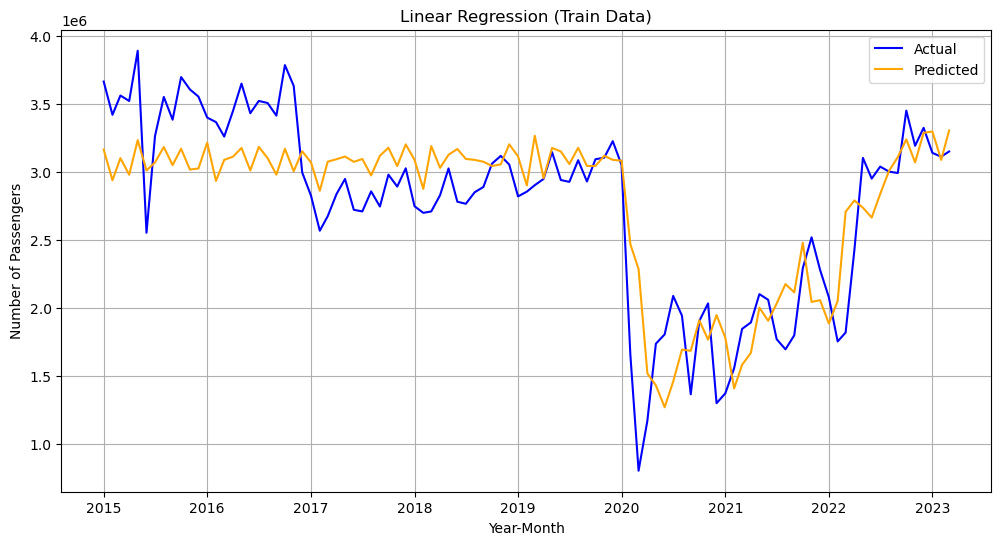

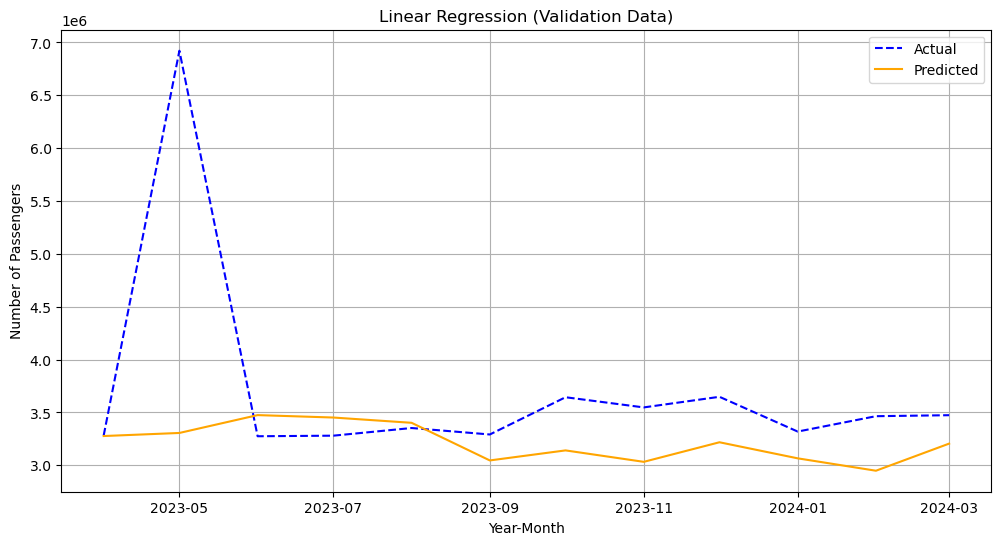

In [5]:
# 선형 회귀 모델 훈련
li_model = LinearRegression()
li_model.fit(X_train_scaled, Y_train)

# 훈련 데이터 예측 및 평가
Y_train_pred = li_model.predict(X_train_scaled)
train_r_squared = r2_score(Y_train, Y_train_pred)
train_mae = mean_absolute_error(Y_train, Y_train_pred)
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100

# 검증 데이터 예측 및 평가
Y_val_pred = li_model.predict(X_val_scaled)
val_r_squared = r2_score(Y_val, Y_val_pred)
val_mae = mean_absolute_error(Y_val, Y_val_pred)
val_mse = mean_squared_error(Y_val, Y_val_pred)
val_mape = np.mean(np.abs((Y_val - Y_val_pred) / Y_val)) * 100

# 결과 출력
print('Train Data:')
print(f'R-squared: {train_r_squared:.2f}')
print(f'MAE: {train_mae:.2f}')
print(f'MSE: {train_mse:.2f}')
print(f'MAPE: {train_mape:.2f}%')
print()
print('Validation Data:')
print(f'R-squared: {val_r_squared:.2f}')
print(f'MAE: {val_mae:.2f}')
print(f'MSE: {val_mse:.2f}')
print(f'MAPE: {val_mape:.2f}%')

# 훈련 데이터 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
plt.title('Linear Regression (Train Data)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# 검증 데이터 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue', linestyle='--')
plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
plt.title('Linear Regression (Validation Data)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

Train Data:
R-squared: 0.94
MAE: 130460.84
MSE: 26085586827.87
MAPE: 5.33%

Validation Data:
R-squared: -0.41
MAE: 586589.31
MSE: 1352952851414.08
MAPE: 12.29%


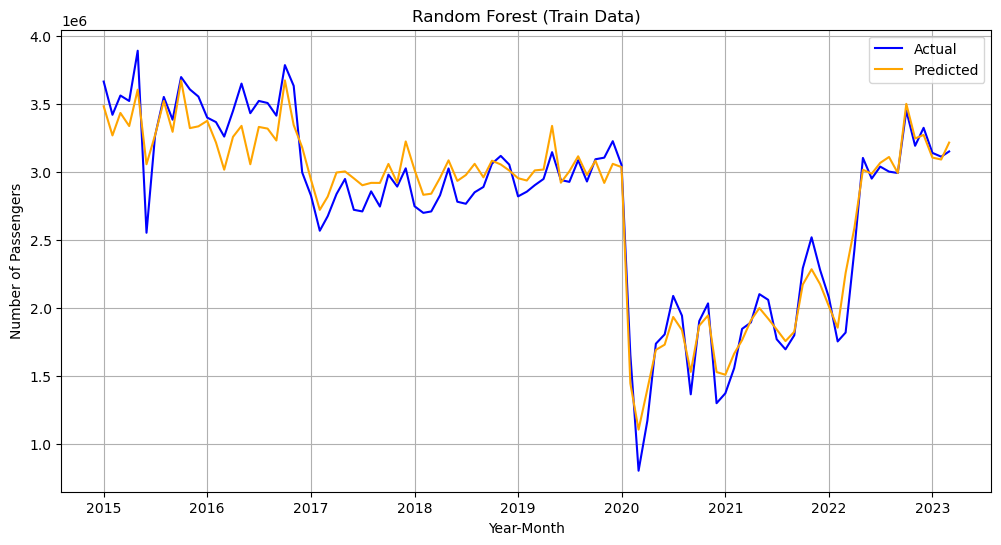

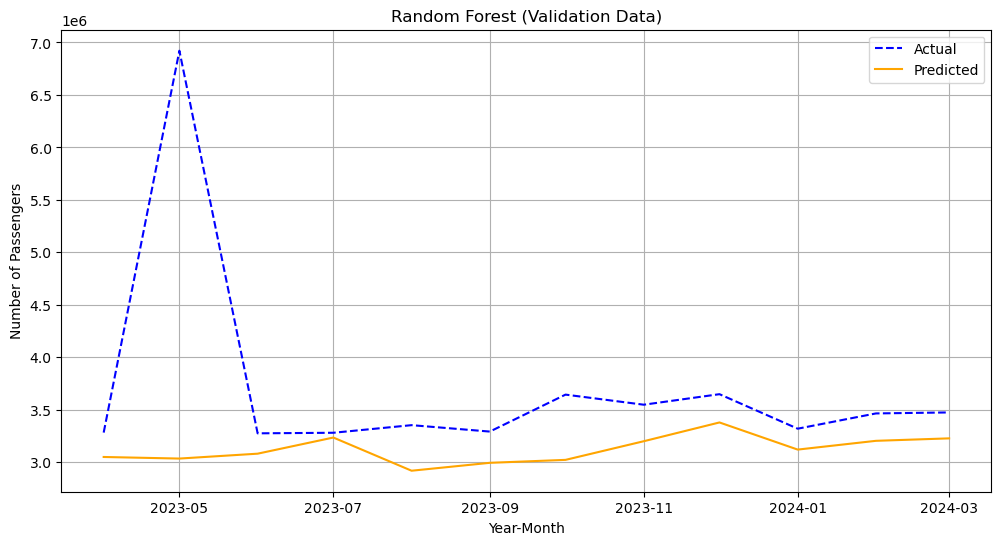

In [6]:
# 랜덤 포레스트 모델 훈련
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train_scaled, Y_train)

# 훈련 데이터 예측 및 평가
Y_train_pred_rf = rf_model.predict(X_train_scaled)
train_r_squared_rf = r2_score(Y_train, Y_train_pred_rf)
train_mae_rf = mean_absolute_error(Y_train, Y_train_pred_rf)
train_mse_rf = mean_squared_error(Y_train, Y_train_pred_rf)
train_mape_rf = np.mean(np.abs((Y_train - Y_train_pred_rf) / Y_train)) * 100

# 검증 데이터 예측 및 평가
Y_val_pred_rf = rf_model.predict(X_val_scaled)
val_r_squared_rf = r2_score(Y_val, Y_val_pred_rf)
val_mae_rf = mean_absolute_error(Y_val, Y_val_pred_rf)
val_mse_rf = mean_squared_error(Y_val, Y_val_pred_rf)
val_mape_rf = np.mean(np.abs((Y_val - Y_val_pred_rf) / Y_val)) * 100

# 결과 출력
print('Train Data:')
print(f'R-squared: {train_r_squared_rf:.2f}')
print(f'MAE: {train_mae_rf:.2f}')
print(f'MSE: {train_mse_rf:.2f}')
print(f'MAPE: {train_mape_rf:.2f}%')
print()
print('Validation Data:')
print(f'R-squared: {val_r_squared_rf:.2f}')
print(f'MAE: {val_mae_rf:.2f}')
print(f'MSE: {val_mse_rf:.2f}')
print(f'MAPE: {val_mape_rf:.2f}%')

# 훈련 데이터 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
plt.plot(train_data['운행년월'], Y_train_pred_rf, label='Predicted', color='orange')
plt.title('Random Forest (Train Data)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# 검증 데이터 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue', linestyle='--')
plt.plot(val_data['운행년월'], Y_val_pred_rf, label='Predicted', color='orange')
plt.title('Random Forest (Validation Data)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

Train Data:
R-squared: 0.98
MAE: 29357.72
MSE: 7959539522.43
MAPE: 0.96%

Validation Data:
R-squared: -0.47
MAE: 596503.40
MSE: 1404204459897.37
MAPE: 12.62%


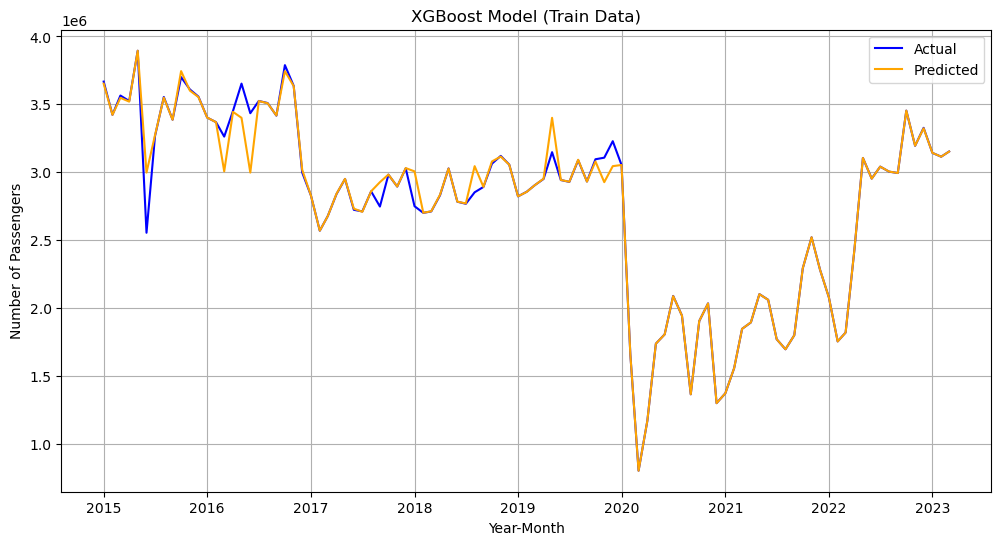

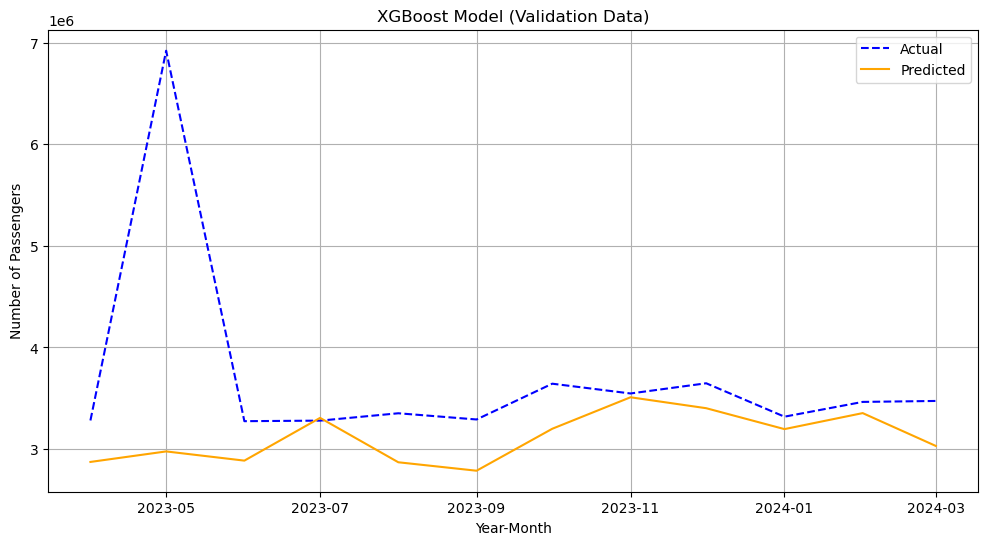

In [7]:
# XGBoost 모델 훈련
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)
xgb_model.fit(X_train_scaled, Y_train)

# 훈련 데이터 예측 및 평가
Y_train_pred_xgb = xgb_model.predict(X_train_scaled)
train_r_squared_xgb = r2_score(Y_train, Y_train_pred_xgb)
train_mae_xgb = mean_absolute_error(Y_train, Y_train_pred_xgb)
train_mse_xgb = mean_squared_error(Y_train, Y_train_pred_xgb)
train_mape_xgb = np.mean(np.abs((Y_train - Y_train_pred_xgb) / Y_train)) * 100

# 검증 데이터 예측 및 평가
Y_val_pred_xgb = xgb_model.predict(X_val_scaled)
val_r_squared_xgb = r2_score(Y_val, Y_val_pred_xgb)
val_mae_xgb = mean_absolute_error(Y_val, Y_val_pred_xgb)
val_mse_xgb = mean_squared_error(Y_val, Y_val_pred_xgb)
val_mape_xgb = np.mean(np.abs((Y_val - Y_val_pred_xgb) / Y_val)) * 100

# 결과 출력
print('Train Data:')
print(f'R-squared: {train_r_squared_xgb:.2f}')
print(f'MAE: {train_mae_xgb:.2f}')
print(f'MSE: {train_mse_xgb:.2f}')
print(f'MAPE: {train_mape_xgb:.2f}%')
print()
print('Validation Data:')
print(f'R-squared: {val_r_squared_xgb:.2f}')
print(f'MAE: {val_mae_xgb:.2f}')
print(f'MSE: {val_mse_xgb:.2f}')
print(f'MAPE: {val_mape_xgb:.2f}%')

# 훈련 데이터 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
plt.plot(train_data['운행년월'], Y_train_pred_xgb, label='Predicted', color='orange')
plt.title('XGBoost Model (Train Data)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# 검증 데이터 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue', linestyle='--')
plt.plot(val_data['운행년월'], Y_val_pred_xgb, label='Predicted', color='orange')
plt.title('XGBoost Model (Validation Data)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
## 2023.05.11 대한민국 코로나 비상사태 종료